## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [19]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt
from scipy.optimize import curve_fit

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [20]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

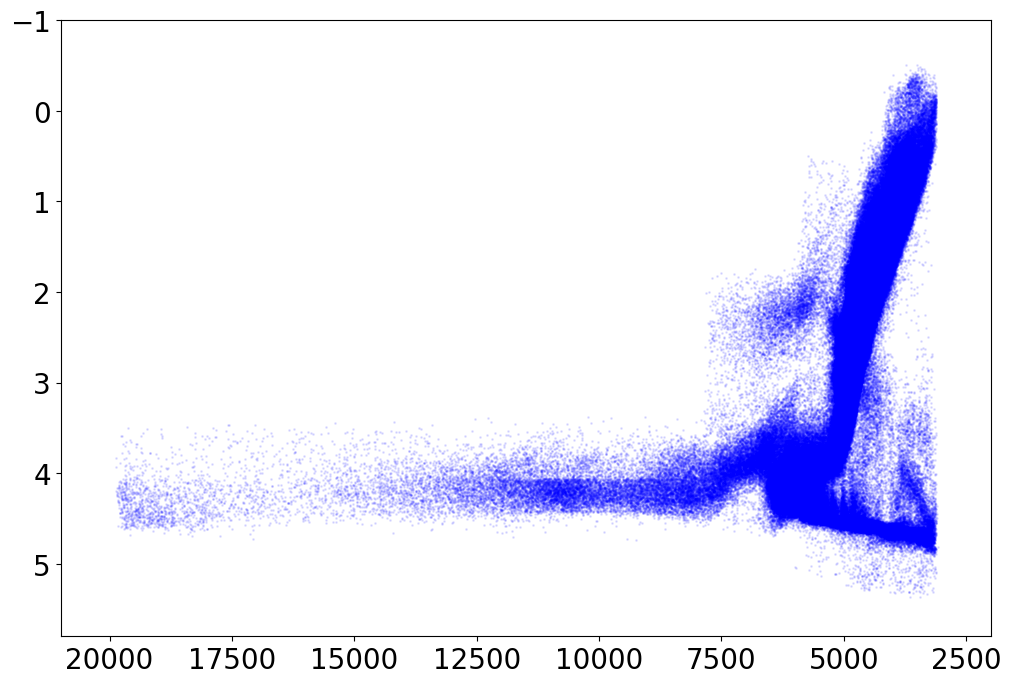

In [21]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.192, 0.058
POLY2: -0.037, -0.226, 0.057
POLY3: 0.089, 0.133, -0.192, 0.049


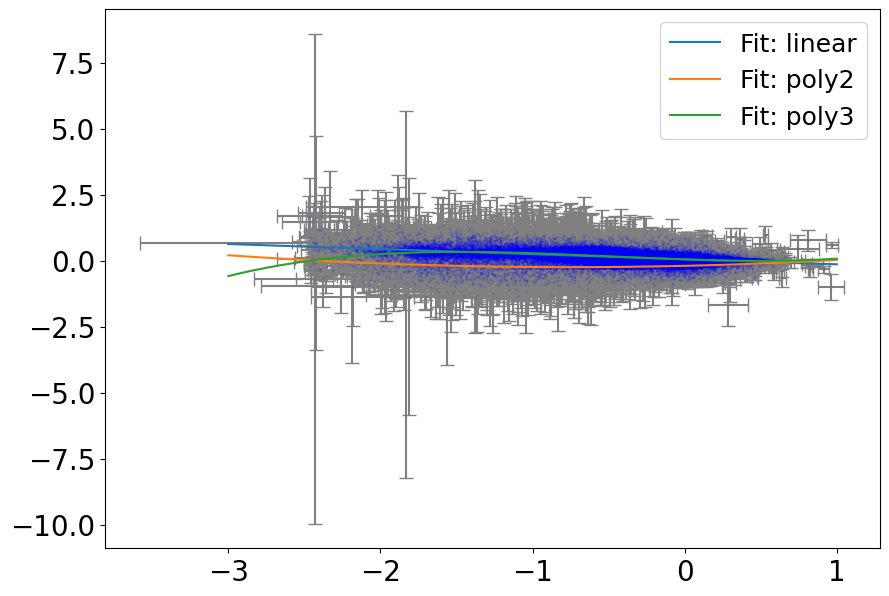

In [107]:
badbits = 2**23        
suspectbits = 2**16    

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 20) & (~np.isnan(star['Fe_H'])) & (~np.isnan(star['O_FE'])) &\
     (star['GLAT'] > -20) 
cut1 = np.where(ct1)[0]

slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['O_Fe_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

polyA, polyB, polyC,polyD  = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD:.3f}')


fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]),
             yerr=(np.abs(star['O_FE_ERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)



x_plot = np.linspace(-3,1,1000) 

ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC ), label='Fit: poly2')

ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD ), label='Fit: poly3')




plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.137, 0.040
POLY2: -0.020, -0.147, 0.041
POLY3: -0.020, -0.147, 0.041, 0.033


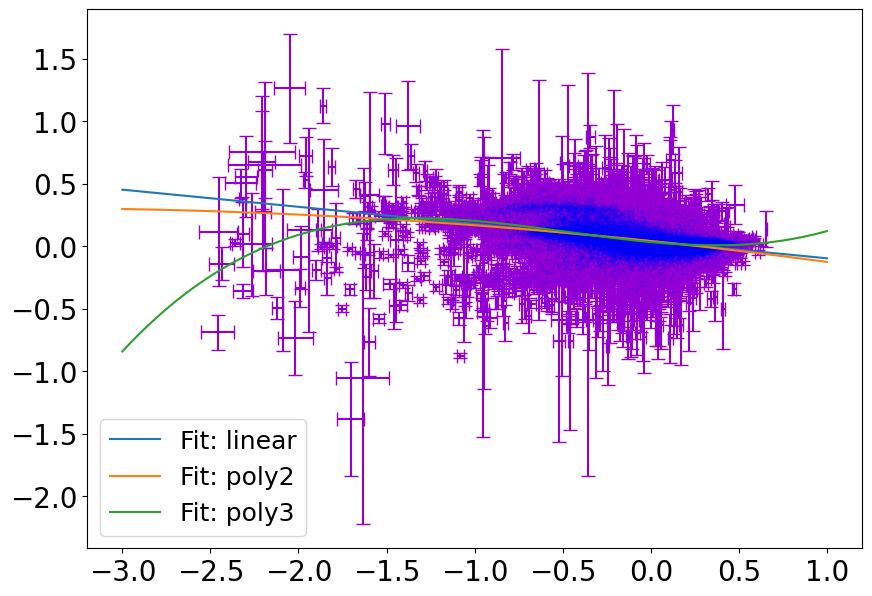

In [109]:
badbits = 2**23        
suspectbits = 2**16    

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 1) & (~np.isnan(star['Fe_H'])) & (~np.isnan(star['O_FE'])) &\
     (star['GLAT'] > -1) 
cut1 = np.where(ct1)[0]

slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['O_Fe_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {poly3D:.3f}')


fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]),
             yerr=(np.abs(star['O_FE_ERR'][cut1])), ecolor='darkviolet',fmt='none', capsize=5, zorder=0)



x_plot = np.linspace(-3,1,1000) 

ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC ), label='Fit: poly2')

ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D ), label='Fit: poly3')




plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: Slope=0.000, Intercept=0.354
EXPONENTIAL: Exp1=-64.052, Exp2=-0.000, Exp3=-1.763, Exp4=4.730
POLY3: Poly3A=0.000, Poly3B=-0.000, Poly3C=0.002, Poly3D=-4.022


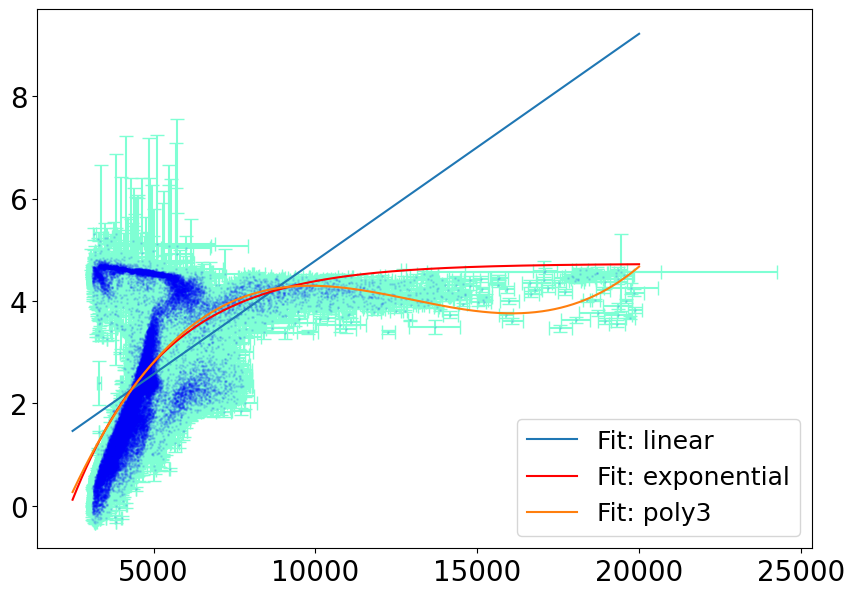

In [110]:
GLON_range = (star['GLON'] > 340) & (star['GLON'] < 360)

star_selected = star[GLON_range]

badbits = 2**23
suspectbits = 2**16

ct1 = (np.bitwise_and(star_selected['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star_selected['starflag'], suspectbits) == 0) & \
      (~np.isnan(star_selected['TEFF'])) & (~np.isnan(star_selected['LOGG']))

cut1 = np.where(ct1)[0]

slope, intercept = mcFit2(linear, star_selected['TEFF'][cut1], star_selected['LOGG'][cut1], star_selected['TEFF_ERR'][cut1],
                          star_selected['LOGG_ERR'][cut1], p0=[0, 0])
print(f'LINEAR: Slope={slope:.3f}, Intercept={intercept:.3f}')

exp1, exp2, exp3, exp4 = mcFit4(exponential, star_selected['TEFF'][cut1], star_selected['LOGG'][cut1], star_selected['TEFF_ERR'][cut1],
                                star_selected['LOGG_ERR'][cut1], p0=[-70, -0.00035, -1.9, 4.7])
print(f'EXPONENTIAL: Exp1={exp1:.3f}, Exp2={exp2:.3f}, Exp3={exp3:.3f}, Exp4={exp4:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, star_selected['TEFF'][cut1], star_selected['LOGG'][cut1], star_selected['TEFF_ERR'][cut1],
                                       star_selected['LOGG_ERR'][cut1], p0=[1, 1, 1, 1])
print(f'POLY3: Poly3A={poly3A:.3f}, Poly3B={poly3B:.3f}, Poly3C={poly3C:.3f}, Poly3D={poly3D:.3f}')

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(star_selected['TEFF'][cut1], star_selected['LOGG'][cut1], s=1, c='b', alpha=0.1)
ax1.errorbar(star_selected['TEFF'][cut1], star_selected['LOGG'][cut1], xerr=star_selected['TEFF_ERR'][cut1],
             yerr=np.abs(star_selected['LOGG_ERR'][cut1]), ecolor='aquamarine', fmt='none', capsize=5, zorder=0)

x_plot = np.linspace(2500, 20000, 1000)

ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: linear')
ax1.plot(x_plot, exponential(x_plot, exp1, exp2, exp3, exp4), label='Fit: exponential', c='r')
ax1.plot(x_plot, poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:


1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: Slope=-0.106, Intercept=4915.397
POLY2: polyA=0.001, polyB=-0.095, polyC=4913.832
POLY3: a=-0.000, b=0.003, c=-0.192, d=4910.669


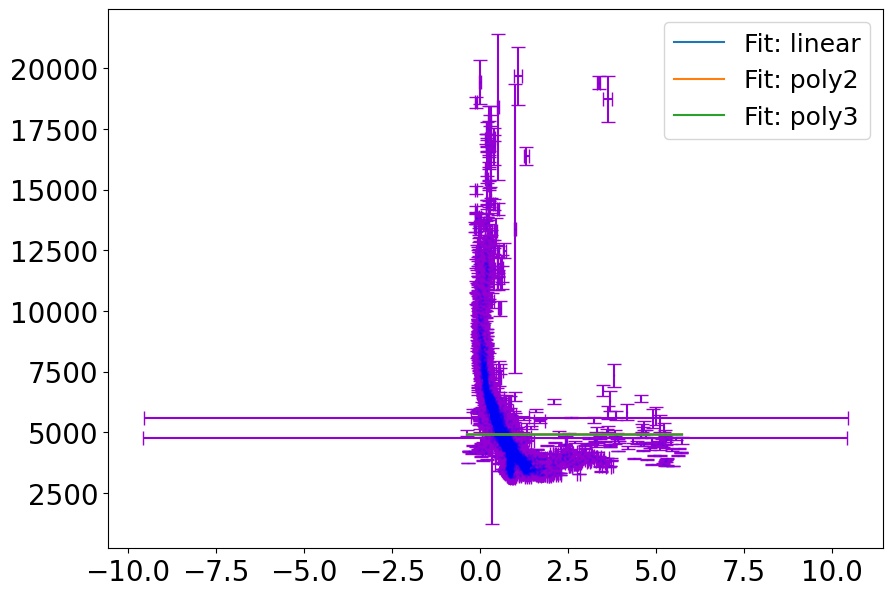

In [111]:
badbits = 2**23
suspectbits = 2**16

def calculate_JK_ERR(J_ERR, K_ERR):
    return np.sqrt(J_ERR**2 + K_ERR**2)

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['DEC'] < -50) & (star['RA'] > 50) & (star['RA'] < 120) & \
     (~np.isnan(star['TEFF']) & ~np.isnan(star['TEFF_ERR']) & ~np.isnan(star['J']) & ~np.isnan(star['K']))

cut1 = np.where(ct1)[0]

# Fit functions
slope, intercept = mcFit2(linear, star['J'][cut1] - star['K'][cut1], star['TEFF'][cut1], star['TEFF_ERR'][cut1], p0=[0, 0])
print(f'LINEAR: Slope={slope:.3f}, Intercept={intercept:.3f}')

polyA, polyB, polyC = mcFit3(poly2, star['J'][cut1] - star['K'][cut1], star['TEFF'][cut1], star['TEFF_ERR'][cut1], p0=[600, 1, 1])
print(f'POLY2: polyA={polyA:.3f}, polyB={polyB:.3f}, polyC={polyC:.3f}')

params_poly3 = mcFit4(poly3, star['J'][cut1] - star['K'][cut1], star['TEFF'][cut1], star['TEFF_ERR'][cut1], p0=[1, 1, 1, 1])
poly3_a, poly3_b, poly3_c, poly3_d = params_poly3
print(f'POLY3: a={poly3_a:.3f}, b={poly3_b:.3f}, c={poly3_c:.3f}, d={poly3_d:.3f}')

JK_ERR = calculate_JK_ERR(star['J_ERR'][cut1], star['K_ERR'][cut1])

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(star['J'][cut1] - star['K'][cut1], star['TEFF'][cut1], s=1, c='b', alpha=0.1)
ax1.errorbar(star['J'][cut1] - star['K'][cut1], star['TEFF'][cut1], xerr=JK_ERR, yerr=star['TEFF_ERR'][cut1],
             ecolor='darkviolet', fmt='none', capsize=5, zorder=0)

x_plot = np.linspace(min(star['J'][cut1] - star['K'][cut1]), max(star['J'][cut1] - star['K'][cut1]), 100)

ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: linear')
ax1.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
ax1.plot(x_plot, poly3(x_plot, poly3_a, poly3_b, poly3_c, poly3_d), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()



## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: Slope=-0.001, Intercept=-3.967
POLY3: a=-0.000, b=0.014, c=-1.780, d=27.961
COSFIT: a=6.358, b=0.980, c=4.444, d=-3.892


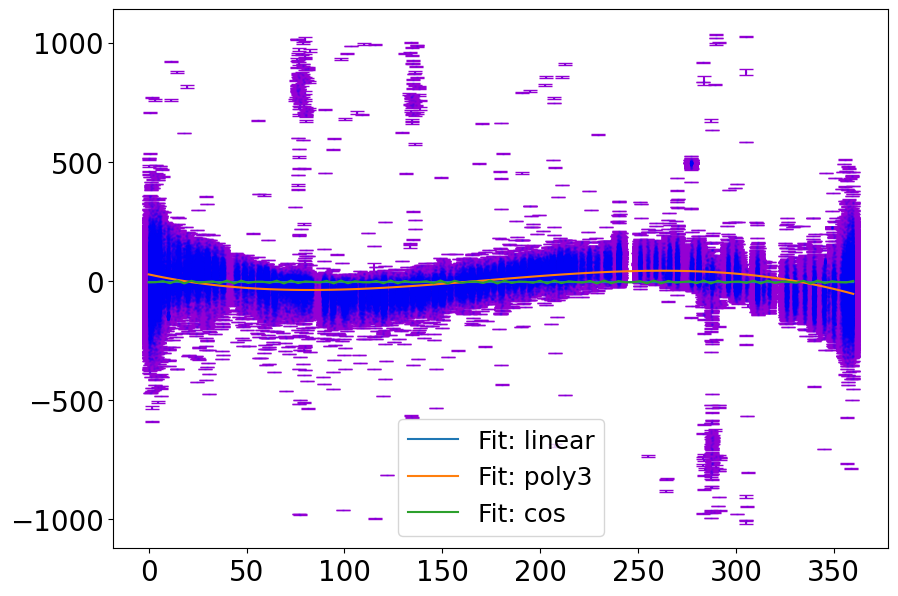

In [11]:

badbits = 2**23
suspectbits = 2**16

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) & (star['GLAT'] < 10)

# Apply selection
cut1 = np.where(ct1)[0]

# Fit functions
slope_linear, intercept_linear = mcFit2(linear, star['GLON'][cut1], star['VHELIO_AVG'][cut1], star['VERR'][cut1], p0=[0, 0])
print(f'LINEAR: Slope={slope_linear:.3f}, Intercept={intercept_linear:.3f}')

poly3a, poly3b, poly3c, poly3d = mcFit4(poly3, star['GLON'][cut1], star['VHELIO_AVG'][cut1], star['VERR'][cut1], p0=[1, 1, 1, 1])
poly3_a, poly3_b, poly3_c, poly3_d = params_poly3
print(f'POLY3: a={poly3a:.3f}, b={poly3b:.3f}, c={poly3c:.3f}, d={poly3d:.3f}')

cosa, cosb, cosc, cosd = mcFit4(cosfit, star['GLON'][cut1], star['VHELIO_AVG'][cut1], star['VERR'][cut1], p0=[1, 1, 1, 1])
print(f'COSFIT: a={cosa:.3f}, b={cosb:.3f}, c={cosc:.3f}, d={cosd:.3f}')

# Plotting
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(star['GLON'][cut1], star['VHELIO_AVG'][cut1], s=1, c='b', alpha=0.1)
ax1.errorbar(star['GLON'][cut1], star['VHELIO_AVG'][cut1], yerr=star['VERR'][cut1],
             ecolor='darkviolet', fmt='none', capsize=5, zorder=0)

x_plot = np.linspace(min(star['GLON'][cut1]), max(star['GLON'][cut1]), 100)

ax1.plot(x_plot, linear(x_plot, slope_linear, intercept_linear), label='Fit: linear')
ax1.plot(x_plot, poly3(x_plot, poly3a, poly3b, poly3c, poly3d), label='Fit: poly3')
ax1.plot(x_plot, cosfit(x_plot, cosa, cosb, cosc, cosd), label='Fit: cos')

plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: Slope=0.015, Intercept=0.777
EXPONENTIAL: Exp1=-9.725, Exp2=-0.366, Exp3=-1.393, Exp4=1.788
POLY3: Poly3_a=-0.000, Poly3_b=-0.005, Poly3_c=0.221, Poly3_d=0.190


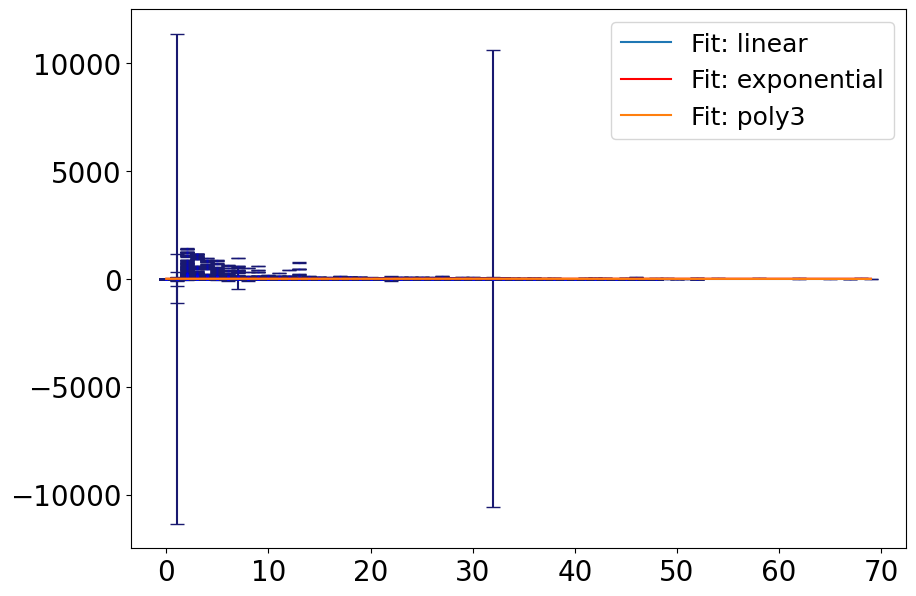

In [25]:
badbits = 2**23
suspectbits = 2**16

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (~np.isnan(star['NVISITS'])) & \
     (~np.isnan(star['VSCATTER'])) & \
     (~np.isnan(star['VERR']))

cut1 = np.where(ct1)[0]

slope, intercept = mcFit2(linear, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1], p0=[0, 0])
print(f'LINEAR: Slope={slope:.3f}, Intercept={intercept:.3f}')

exp_params, exp_covariance = curve_fit( exponential, star['NVISITS'][cut1],star['VSCATTER'][cut1],p0=[-2.5, -0.37, -1, -1.7],maxfev=2000) 

exp1, exp2, exp3, exp4 = exp_params
print(f'EXPONENTIAL: Exp1={exp1:.3f}, Exp2={exp2:.3f}, Exp3={exp3:.3f}, Exp4={exp4:.3f}')

poly3_a, poly3_b, poly3_c, poly3_d = mcFit4(poly3, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1], p0=[1, 1, 1, 1])
print(f'POLY3: Poly3_a={poly3_a:.3f}, Poly3_b={poly3_b:.3f}, Poly3_c={poly3_c:.3f}, Poly3_d={poly3_d:.3f}')

fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(star['NVISITS'], star['VSCATTER'], s=1, c='b', alpha=0.1)
ax1.errorbar(star['NVISITS'], star['VSCATTER'], yerr=star['VERR'],
             ecolor='midnightblue', fmt='none', capsize=5, zorder=0)

x_plot = np.linspace(min(star['NVISITS']), max(star['NVISITS']), 1000)

ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: linear')
ax1.plot(x_plot, exponential(x_plot, exp1, exp2, exp3, exp4), label='Fit: exponential', c='r')
ax1.plot(x_plot, poly3(x_plot, poly3_a, poly3_b, poly3_c, poly3_d), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.006, 0.009
POLY2: 0.132, 0.073, 0.004
POLY3: 0.018, 0.163, 0.077, 0.002


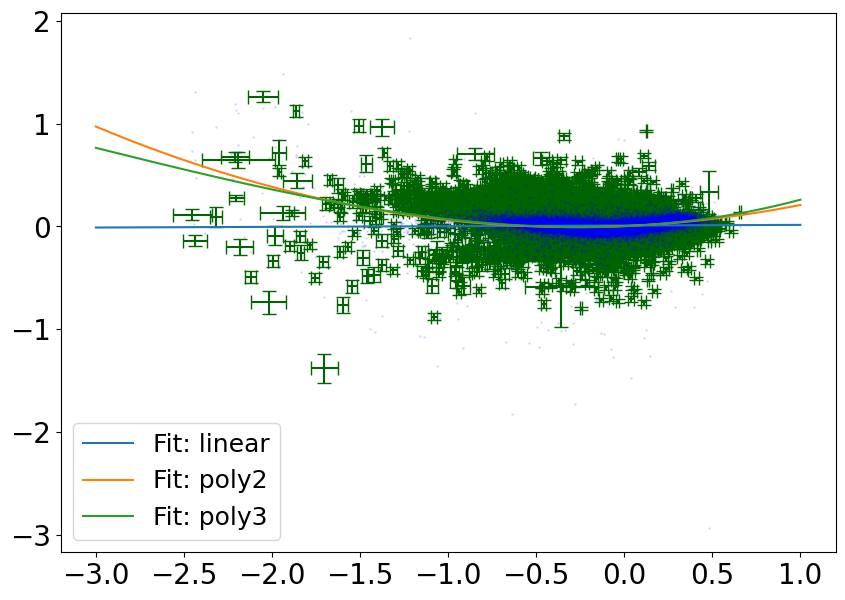

In [5]:
badbits = 2**23        
suspectbits = 2**16    

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 1) & (~np.isnan(star['Fe_H'])) & (~np.isnan(star['NI_FE'])) &\
     (star['GLAT'] > -1) 
cut1 = np.where(ct1)[0]

slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['NI_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['NI_FE_ERR'][cut1],p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

poly3A, poly3B, poly3C,poly3D  = mcFit4(poly3, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['NI_FE_ERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(star['Fe_H'][cut1],star['NI_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]),
             yerr=(np.abs(star['NI_FE_ERR'][cut1])), ecolor='darkgreen',fmt='none', capsize=5, zorder=0)



x_plot = np.linspace(-3,1,1000) 

ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC ), label='Fit: poly2')

ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D ), label='Fit: poly3')




plt.legend(loc='best', fontsize=18)
plt.show()
